In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import zipfile
import os
from tqdm import tqdm

In [2]:
import kagglehub


path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/plantvillage-dataset


In [3]:
path = "/kaggle/input/plantvillage-dataset/color"

In [4]:

for class_name in sorted(os.listdir(path)):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):
     
        image_count = sum(
            1 for file in os.listdir(class_path)
            if os.path.isfile(os.path.join(class_path, file))
        )
        print(f"{class_name}: {image_count} images")

Apple___Apple_scab: 630 images
Apple___Black_rot: 621 images
Apple___Cedar_apple_rust: 275 images
Apple___healthy: 1645 images
Blueberry___healthy: 1502 images
Cherry_(including_sour)___Powdery_mildew: 1052 images
Cherry_(including_sour)___healthy: 854 images
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 513 images
Corn_(maize)___Common_rust_: 1192 images
Corn_(maize)___Northern_Leaf_Blight: 985 images
Corn_(maize)___healthy: 1162 images
Grape___Black_rot: 1180 images
Grape___Esca_(Black_Measles): 1383 images
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1076 images
Grape___healthy: 423 images
Orange___Haunglongbing_(Citrus_greening): 5507 images
Peach___Bacterial_spot: 2297 images
Peach___healthy: 360 images
Pepper,_bell___Bacterial_spot: 997 images
Pepper,_bell___healthy: 1478 images
Potato___Early_blight: 1000 images
Potato___Late_blight: 1000 images
Potato___healthy: 152 images
Raspberry___healthy: 371 images
Soybean___healthy: 5090 images
Squash___Powdery_mildew: 1835 images
S

In [5]:
import os
import shutil
import random
from pathlib import Path


random.seed(42)


source_dir = '/kaggle/input/plantvillage-dataset/color'
dest_dir   = '/kaggle/working/plantvillage-balanced'
min_required = 350


os.makedirs(dest_dir, exist_ok=True)


class_counts = {}
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if os.path.isdir(class_path):
        image_files = [f for f in os.listdir(class_path)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(image_files)

print("Found classes:", len(class_counts))
print("Counts per class:", class_counts)


kept, skipped = [], []
for class_name, count in class_counts.items():
    src_class_path = os.path.join(source_dir, class_name)
    dst_class_path = os.path.join(dest_dir, class_name)

   
    if count < min_required:
        skipped.append((class_name, count))
        continue

    os.makedirs(dst_class_path, exist_ok=True)

    
    image_files = [f for f in os.listdir(src_class_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

   
    sampled_files = random.sample(image_files, min_required)

    for filename in sampled_files:
        src = os.path.join(src_class_path, filename)
        dst = os.path.join(dst_class_path, filename)
        shutil.copy2(src, dst)

    kept.append((class_name, min_required))

print("\nSummary")
print("---------")
print(f"Kept classes (exactly {min_required} each): {len(kept)}")
for name, cnt in kept:
    print(f"  - {name}: {cnt}")

print(f"\nSkipped classes (< {min_required} images): {len(skipped)}")
for name, cnt in skipped:
    print(f"  - {name}: {cnt}")

print("\nBalanced dataset created at:", dest_dir)

Found classes: 38
Counts per class: {'Tomato___Late_blight': 1909, 'Tomato___healthy': 1591, 'Grape___healthy': 423, 'Orange___Haunglongbing_(Citrus_greening)': 5507, 'Soybean___healthy': 5090, 'Squash___Powdery_mildew': 1835, 'Potato___healthy': 152, 'Corn_(maize)___Northern_Leaf_Blight': 985, 'Tomato___Early_blight': 1000, 'Tomato___Septoria_leaf_spot': 1771, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 513, 'Strawberry___Leaf_scorch': 1109, 'Peach___healthy': 360, 'Apple___Apple_scab': 630, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 5357, 'Tomato___Bacterial_spot': 2127, 'Apple___Black_rot': 621, 'Blueberry___healthy': 1502, 'Cherry_(including_sour)___Powdery_mildew': 1052, 'Peach___Bacterial_spot': 2297, 'Apple___Cedar_apple_rust': 275, 'Tomato___Target_Spot': 1404, 'Pepper,_bell___healthy': 1478, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 1076, 'Potato___Late_blight': 1000, 'Tomato___Tomato_mosaic_virus': 373, 'Strawberry___healthy': 456, 'Apple___healthy': 1645, 'Grape

In [6]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),     
    transforms.RandomHorizontalFlip(),      
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


dataset = datasets.ImageFolder(root="/kaggle/working/plantvillage-balanced", transform=transform_train)
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])



val_dataset.dataset.transform = transform_test
test_dataset.dataset.transform = transform_test

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = dataset.classes
num_classes = len(class_names)

In [7]:
class_names = dataset.classes
num_classes = len(class_names)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_names = train_dataset.dataset.classes
total_class = len(class_names)

learning_rate = 0.0001

model = models.mobilenet_v2(pretrained=True)

for param in model.parameters():
    param.requires_grad = False


num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, total_class)

model = model.to(device)

optimizer = optim.Adam(model.classifier[1].parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

summary(model, input_size=(3, 224, 224))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 152MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [9]:
class EarlyStopping:

    def __init__(self, patience=5):

        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf

    def check_early_stop(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [10]:
from time import perf_counter
from tqdm import tqdm  
from torch.cuda.amp import autocast, GradScaler  
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim

num_epochs = 50  

model = models.mobilenet_v2(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.classifier[1].parameters(), lr=0.001)  

early_stopping = EarlyStopping(patience=5)  
train_losses, val_losses = [], []  

scaler = GradScaler()

total_train_t0 = perf_counter()
epoch_times = []

for epoch in range(num_epochs):
    t_epoch0 = perf_counter()
    print(f"Epoch {epoch+1}/{num_epochs}")

    model.train()
    train_loss = 0
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast(enabled=(device.type == "cuda")):
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            with autocast(enabled=(device.type == "cuda")):
                outputs = model(images)
                loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    t_epoch1 = perf_counter()
    epoch_times.append(t_epoch1 - t_epoch0)
    print(f"Epoch {epoch+1} time: {epoch_times[-1]:.2f} s")

    if early_stopping.check_early_stop(avg_val_loss):
        print("Early stopping triggered.")
        break

total_train_t1 = perf_counter()
total_training_time_s = total_train_t1 - total_train_t0
avg_epoch_time_s = (sum(epoch_times)/len(epoch_times)) if epoch_times else float('nan')

print(f"\nTotal training time: {total_training_time_s:.2f} s")
print(f"Average per-epoch time: {avg_epoch_time_s:.2f} s")


/tmp/ipykernel_18/3341901340.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/50


Training:   0%|          | 0/276 [00:00<?, ?it/s]/tmp/ipykernel_18/3341901340.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):
Validation:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipykernel_18/3341901340.py:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


Train Loss: 1.0470, Validation Loss: 0.3661
Epoch 1 time: 32.07 s
Epoch 2/50


Train Loss: 0.3428, Validation Loss: 0.2520
Epoch 2 time: 31.27 s
Epoch 3/50


Train Loss: 0.2392, Validation Loss: 0.2045
Epoch 3 time: 31.21 s
Epoch 4/50


Train Loss: 0.1924, Validation Loss: 0.1681
Epoch 4 time: 31.12 s
Epoch 5/50


Train Loss: 0.1689, Validation Loss: 0.1496
Epoch 5 time: 31.05 s
Epoch 6/50


Train Loss: 0.1455, Validation Loss: 0.1386
Epoch 6 time: 31.17 s
Epoch 7/50


Train Loss: 0.1324, Validation Loss: 0.1321
Epoch 7 time: 31.12 s
Epoch 8/50


Train Loss: 0.1153, Validation Loss: 0.1234
Epoch 8 time: 31.22 s
Epoch 9/50


Train Loss: 0.1115, Validation Loss: 0.1316
Epoch 9 time: 31.27 s
Epoch 10/50


Train Loss: 0.1003, Validation Loss: 0.1204
Epoch 10 time: 31.96 s
Epoch 11/50


Train Loss: 0.0979, Validation Loss: 0.1216
Epoch 11 time: 31.60 s
Epoch 12/50


Train Loss: 0.0981, Validation Loss: 0.1150
Epoch 12 time: 31.58 s
Epoch 13/50


Train Loss: 0.0878, Validation Loss: 0.1351
Epoch 13 time: 31.88 s
Epoch 14/50


Train Loss: 0.0829, Validation Loss: 0.1161
Epoch 14 time: 31.62 s
Epoch 15/50


Train Loss: 0.0854, Validation Loss: 0.1236
Epoch 15 time: 31.00 s
Epoch 16/50


Train Loss: 0.0787, Validation Loss: 0.1164
Epoch 16 time: 31.04 s
Epoch 17/50


Train Loss: 0.0762, Validation Loss: 0.1387
Epoch 17 time: 30.96 s
Early stopping triggered.

Total training time: 533.13 s
Average per-epoch time: 31.36 s


In [11]:

model_save_path = "mobilenet_v2_model.pth"  


torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")


Model saved to mobilenet_v2_model.pth


In [12]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to('cuda'), labels.to('cuda')
        with autocast():
            outputs = model(images)
        preds = torch.argmax(outputs, dim=1)  
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


report = classification_report(all_labels, all_preds, digits=4)
print("Classification Report:\n", report)


/tmp/ipykernel_18/2379966855.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Classification Report:
               precision    recall  f1-score   support

           0     0.9184    0.8824    0.9000        51
           1     0.8800    1.0000    0.9362        66
           2     0.9254    0.9118    0.9185        68
           3     1.0000    1.0000    1.0000        75
           4     0.9672    0.9219    0.9440        64
           5     1.0000    1.0000    1.0000        69
           6     0.9778    0.6377    0.7719        69
           7     1.0000    0.9750    0.9873        80
           8     0.7407    0.9756    0.8421        82
           9     0.9688    1.0000    0.9841        62
          10     1.0000    0.9672    0.9833        61
          11     0.9714    1.0000    0.9855        68
          12     1.0000    0.9853    0.9926        68
          13     0.9863    1.0000    0.9931        72
          14     1.0000    1.0000    1.0000        72
          15     1.0000    0.8701    0.9306        77
          16     0.9080    1.0000    0.9518        79
   

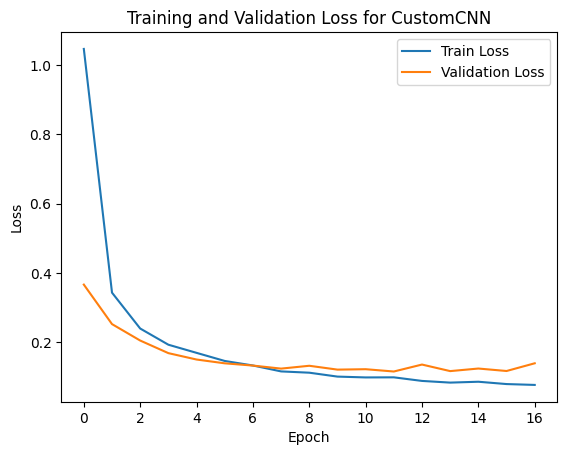

In [13]:
# Plotting loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss for CustomCNN")
plt.show()

/tmp/ipykernel_18/1362086699.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


Testing time: 3.35 sec  |  Throughput: 376.53 samples/sec
Confusion Matrix:
 [[36  1  0 ...  0  0  0]
 [ 0 28  0 ...  0  0  0]
 [ 0  0 31 ...  0  0  0]
 ...
 [ 0  0  0 ... 30  0  0]
 [ 0  0  0 ...  0 36  0]
 [ 0  0  0 ...  0  0 29]]

Confusion Matrix (row-normalized):
[[0.947 0.026 0.    ... 0.    0.    0.   ]
 [0.    1.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.912 ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.938 0.    0.   ]
 [0.    0.    0.    ... 0.    1.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.967]]


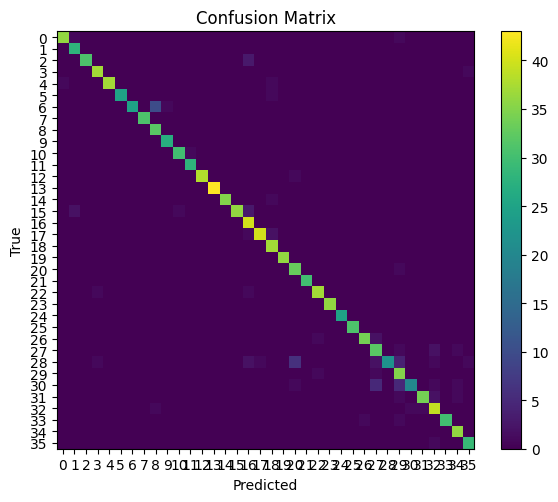

Per-class ROC AUC:
  Class 0: 0.9995
  Class 1: 1.0000
  Class 2: 0.9998
  Class 3: 0.9997
  Class 4: 1.0000
  Class 5: 0.9998
  Class 6: 0.9984
  Class 7: 1.0000
  Class 8: 0.9985
  Class 9: 1.0000
  Class 10: 1.0000
  Class 11: 1.0000
  Class 12: 1.0000
  Class 13: 1.0000
  Class 14: 0.9999
  Class 15: 0.9995
  Class 16: 0.9999
  Class 17: 0.9993
  Class 18: 0.9996
  Class 19: 1.0000
  Class 20: 0.9994
  Class 21: 1.0000
  Class 22: 0.9997
  Class 23: 1.0000
  Class 24: 1.0000
  Class 25: 1.0000
  Class 26: 0.9997
  Class 27: 0.9928
  Class 28: 0.9916
  Class 29: 0.9977
  Class 30: 0.9926
  Class 31: 0.9994
  Class 32: 0.9946
  Class 33: 0.9999
  Class 34: 0.9999
  Class 35: 0.9998
Micro-average ROC AUC: 0.9990
Macro-average ROC AUC: 0.9990


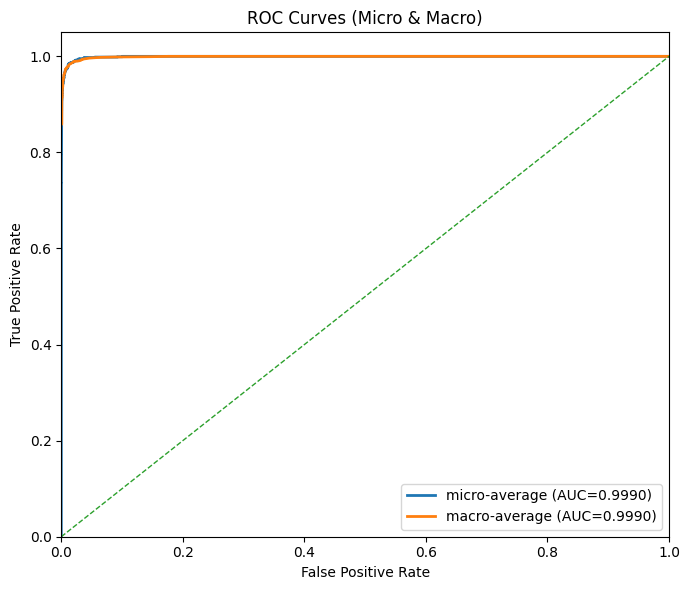

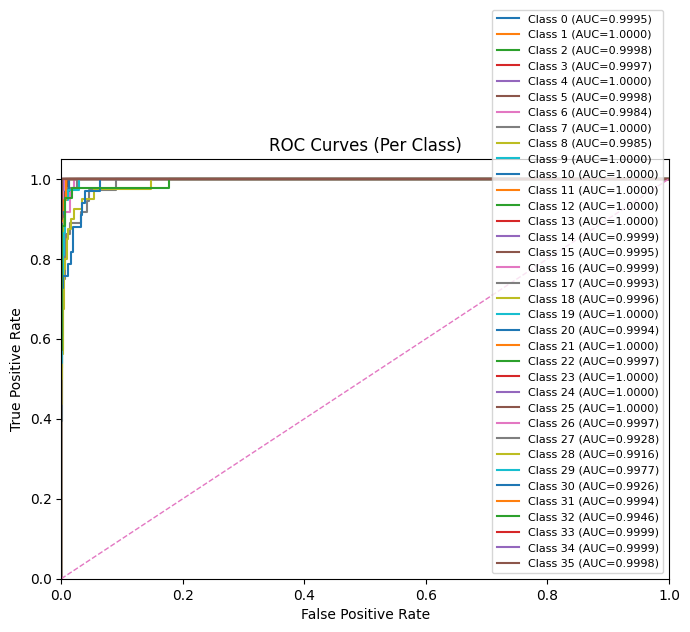


Classification Report (test):
              precision    recall  f1-score   support

           0     0.9730    0.9474    0.9600        38
           1     0.9032    1.0000    0.9492        28
           2     1.0000    0.9118    0.9538        34
           3     0.9487    0.9737    0.9610        38
           4     1.0000    0.9487    0.9737        39
           5     1.0000    0.9615    0.9804        26
           6     1.0000    0.6944    0.8197        36
           7     1.0000    1.0000    1.0000        31
           8     0.7442    1.0000    0.8533        32
           9     0.9643    1.0000    0.9818        27
          10     0.9677    0.9677    0.9677        31
          11     0.9655    1.0000    0.9825        28
          12     1.0000    0.9744    0.9870        39
          13     1.0000    1.0000    1.0000        43
          14     1.0000    0.9722    0.9859        36
          15     1.0000    0.8571    0.9231        42
          16     0.8000    1.0000    0.8889       

In [14]:
from time import perf_counter
import time
import numpy as np
import torch
import torch.nn.functional as F
from torch.cuda.amp import autocast
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, roc_curve, auc, classification_report
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()

all_logits = []
all_probs = []
all_preds = []
all_labels = []

loader = test_loader

t_test_start = time.time()
with torch.no_grad():
    test_t0 = perf_counter()
    n_images_tested = 0
    for images, labels in loader:
        n_images_tested += images.size(0)
        images, labels = images.to(device), labels.to(device)
        with autocast(enabled=(device.type == "cuda")):
            logits = model(images)
            probs = F.softmax(logits, dim=1)

        preds = torch.argmax(probs, dim=1)

        all_logits.append(logits.detach().cpu().numpy())
        all_probs.append(probs.detach().cpu().numpy())
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())

t_test_end = time.time()
total_test_time_sec = t_test_end - t_test_start
n_samples = len(all_preds)
print(f"Testing time: {total_test_time_sec:.2f} sec  |  Throughput: {n_samples/total_test_time_sec:.2f} samples/sec")

all_logits = np.concatenate(all_logits, axis=0)
all_probs = np.concatenate(all_probs, axis=0)
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

num_classes = all_probs.shape[1]
class_indices = list(range(num_classes))

cm = confusion_matrix(all_labels, all_preds, labels=class_indices)
print("Confusion Matrix:\n", cm)

def print_cm(cm):
    row_sums = cm.sum(axis=1, keepdims=True).clip(min=1)
    norm_cm = cm / row_sums
    print("\nConfusion Matrix (row-normalized):")
    with np.printoptions(precision=3, suppress=True):
        print(norm_cm)

print_cm(cm)

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

y_true_bin = label_binarize(all_labels, classes=class_indices) if num_classes > 2 else all_labels
y_score = all_probs

if num_classes == 2:
    fpr, tpr, _ = roc_curve(y_true_bin, y_score[:, 1])
    roc_auc = auc(fpr, tpr)
    print(f"Binary ROC AUC: {roc_auc:.4f}")

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Binary)')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
else:
    fpr = {}
    tpr = {}
    roc_auc = {}
    for c in class_indices:
        fpr[c], tpr[c], _ = roc_curve(y_true_bin[:, c], y_score[:, c])
        roc_auc[c] = auc(fpr[c], tpr[c])

    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[c] for c in class_indices]))
    mean_tpr = np.zeros_like(all_fpr)
    for c in class_indices:
        mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])
    mean_tpr /= num_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    print("Per-class ROC AUC:")
    for c in class_indices:
        print(f"  Class {c}: {roc_auc[c]:.4f}")
    print(f"Micro-average ROC AUC: {roc_auc['micro']:.4f}")
    print(f"Macro-average ROC AUC: {roc_auc['macro']:.4f}")

    plt.figure(figsize=(7, 6))
    plt.plot(fpr["micro"], tpr["micro"], lw=2, label=f'micro-average (AUC={roc_auc["micro"]:.4f})')
    plt.plot(fpr["macro"], tpr["macro"], lw=2, label=f'macro-average (AUC={roc_auc["macro"]:.4f})')
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (Micro & Macro)')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7, 6))
    for c in class_indices:
        plt.plot(fpr[c], tpr[c], lw=1.5, label=f'Class {c} (AUC={roc_auc[c]:.4f})')
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (Per Class)')
    plt.legend(loc="lower right", fontsize=8)
    plt.tight_layout()
    plt.show()

print("\nClassification Report (test):")
print(classification_report(all_labels, all_preds, digits=4))

test_t1 = perf_counter()
total_test_time_s = test_t1 - test_t0
avg_per_image_ms = (total_test_time_s / max(1, n_images_tested)) * 1000.0
print(f"\nTotal test inference time: {total_test_time_s:.2f} s for {n_images_tested} images")
print(f"Average per-image inference time: {avg_per_image_ms:.2f} ms")

In [15]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git


!pip install lime

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-r8nf4pyw
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-r8nf4pyw
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3

In [16]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

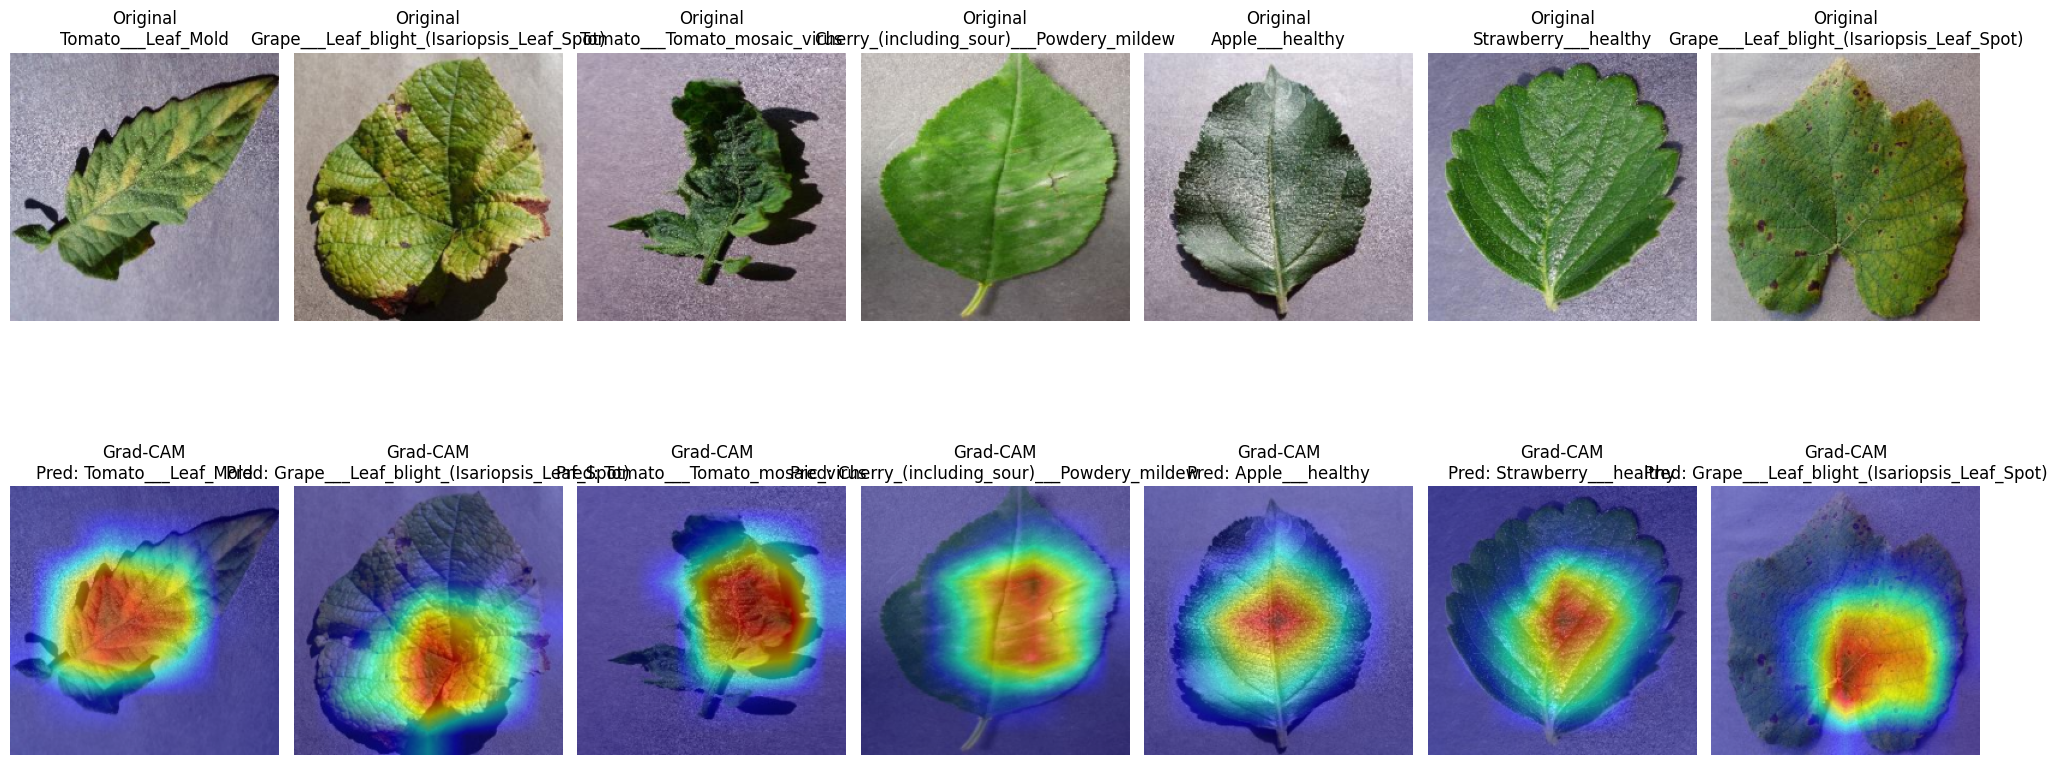

In [17]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval().to(device)

for p in model.features[-1].parameters():
    p.requires_grad_(True)


target_layers = [model.features[-1]]
cam = GradCAM(model=model, target_layers=target_layers)


plt.figure(figsize=(20, 10))

for idx in range(7):
    sample_image, label = test_dataset[idx]
    sample_image = sample_image.unsqueeze(0).to(device)


    original_image_np = sample_image.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    original_image_np = (original_image_np * 0.5) + 0.5   # denormalize
    original_image_np = original_image_np.clip(0, 1)

    outputs = model(sample_image)
    predicted_class = outputs.argmax(dim=1).item()

  
    targets = [ClassifierOutputTarget(predicted_class)]


    grayscale_cam = cam(input_tensor=sample_image, targets=targets, eigen_smooth=True)
    heatmap = grayscale_cam[0]


    result = show_cam_on_image(original_image_np, heatmap, use_rgb=True)


    plt.subplot(2, 7, idx+1)
    plt.title(f"Original\n{class_names[label]}")
    plt.imshow(original_image_np)
    plt.axis('off')

    plt.subplot(2, 7, idx+1+7)
    plt.title(f"Grad-CAM\nPred: {class_names[predicted_class]}")
    plt.imshow(result)
    plt.axis('off')

plt.tight_layout()
plt.show()
